In [ ]:
from airflow import DAG
from airflow.operators.python import PythonOperator
from datetime import datetime

import pandas as pd
import requests
import os

# ------------------------------
# ETL Task Functions
# ------------------------------

def extract_data(**context):
    """Extract data from Random User API"""
    url = "https://randomuser.me/api/?results=10"
    response = requests.get(url)
    data = response.json()
    # Push raw data to XCom (Airflow's internal message passing)
    context['ti'].xcom_push(key='raw_data', value=data)
    print("Extracted data from API")


def transform_data(**context):
    """Transform raw JSON data into a clean DataFrame"""
    raw_data = context['ti'].xcom_pull(key='raw_data', task_ids='extract_task')
    users = raw_data['results']

    # Extract selected fields
    records = []
    for user in users:
        records.append({
            'name': f"{user['name']['first']} {user['name']['last']}",
            'email': user['email'],
            'country': user['location']['country'],
            'age': user['dob']['age']
        })

    df = pd.DataFrame(records)
    context['ti'].xcom_push(key='clean_data', value=df.to_json())
    print(" Transformed data successfully")


def load_data(**context):
    """Load cleaned data into a CSV file"""
    clean_json = context['ti'].xcom_pull(key='clean_data', task_ids='transform_task')
    df = pd.read_json(clean_json)
    os.makedirs('/tmp/airflow_output', exist_ok=True)
    output_path = '/tmp/airflow_output/users_data.csv'
    df.to_csv(output_path, index=False)
    print(f" Data loaded into {output_path}")


# ------------------------------
# DAG Definition
# ------------------------------
with DAG(
    dag_id="real_etl_pipeline",
    start_date=datetime(2025, 12,4),
    schedule_interval="@daily",
    catchup=False,
    tags=["ETL", "example", "pandas"],
) as dag:

    extract_task = PythonOperator(
        task_id="extract_task",
        python_callable=extract_data,
        provide_context=True
    )

    transform_task = PythonOperator(
        task_id="transform_task",
        python_callable=transform_data,
        provide_context=True
    )

    load_task = PythonOperator(
        task_id="load_task",
        python_callable=load_data,
        provide_context=True
    )

    # Set dependency order: Extract → Transform → Load
extract_task >> transform_task >> load_task

In [ ]:
DAG 
Task1 -->Task2 -->Task3
Airflow
=========
1. DAG 
2. executor
3. webserver
4. scheduler 
5. operator 
        |->BashOperator |->PythonOperator 
XCom - cross-communication

In [ ]:
Recap
======
pandas - data - batch data
pyspark - data - batch data + live stream data
               - deltalake usecase 
|
Flink + kafaka
------------------------//project ==> airflow - DAG()
|
model 
|
streamamlit,flask
|
MLApp

In [ ]:
DeltaLake 
----------
 |->Storage Layer
 |->Schema enforcement 

 my_table/
    part-...parquet

Parquet
 |-> columnar storage file format

id: [1,2,3]
name: ['A','B','C]
--------------------

df.to_csv('r1.csv')
df.to_parquet('r1.parquet') --> pd.read_parquet('r1.parquet')

my_table/
  |->data files(Parquet)
  |->Transcation log
  |->Checkpoints
  |->Metadata(schema,partition)

## Activate pyspark-env 
source pyspark-env/bin/activate
(pyspark-env)
 |-------------> pip install delta-spark 

## 1. spark session object
## 2. import delta module ->configure_spark_with_delta_pip

## configuration -> spark.sql.extensions -> io.delta.sql.DeltaSparkSessionExtension 

## 
## lake_table - define path
|
  create a dataframe and write as delta table
  |
  read data from local delta-table 
##
##
--------------------------------------------------------------------
from pyspark.sql import SparkSession
from delta import configure_spark_with_delta_pip

builder = SparkSession.builder.appName("deltalake-demo").master("local[*]").config("spark.sql.extensions","io.delta.sql.DeltaSparkSessionExtension")
.config("spark.sql.catalog.spark_catalog","org.apache.spark.sql.delta.catalog.DeltaCatalog")

spark = configure_spark_with_delta_pip(builder).getOrCreate()

lake_path = "file:///home/student/users"

# lake_path = "s3a://your-bucket-name/delta-lake/user"

# create a dataframe and write as delta-table

data = [(101,"raj"),(102,"leo"),(103,"tom")]

df = spark.createDataFrame(data,["id","name"])
df.write.format("delta").mode("overwrite").save(lake_path)

# Read data from delta table

df_read = spark.read.format("delta").load(lake_path)
df_read.show()       

In [ ]:
### Apache Flink 
| |
|-> like pyspark stream 

|->Batch process |->Realtime stream processing |->in memory processing |-> graph processing 
|
|--> Flink Kernel 

    
|-> DataSet API 
|-> DataStream API 
|-> Table 

|-> Gelly - graph processing
|-> Flink ML 


Pyspark-stream - read/input_stread - from socket,file,kafa 
                 outputsink - console ...
Flink-stream - Kafa ; filesystem; JDBC ; Hive..
              output sinks - kafa ; s3 ..DeltaLake JDBC ..


Kafka
-----
 |-> producer 
 |-> topic - category - where the message are stores
 |-> partition - all the topics are split into partitions 
      Partition 0: [msg1,msg2,msg3]
      Partition 1: [msg4,msg5,msg6]


 |-> consumer 
       |->application read the message from Kafka 

=======================================================================================
Kafak-->Flink/Spark-Stream  --->Delta Lake
----------------------------------------------//schedule to Airflow 


In [ ]:
Kafa_flink_pipeline
|
create project directory
|
| -> pipeline - code - Flink job
| -> producer  - code - kafka producer code
Labset up
|
kafka => kafka.apache.org 
|
Start Zookeeper 
------------------

Start Kafka broker
-----------------

Create topic
------------
|
|
pipeline-code 
install pyflink kafka-python

|->json
|->pyflink
|-> |->kafka config
          |-> localhost:9092

       |->FlinkKafkaConsumer 
           ..

## Reads messages from Kafka 
## Parse as json
## Extract data - field(key)
## Display 

## Create a new direcotry (ex: mkdir Flink_Kafka_demo)
  |
  Go to the Directory => cd Flink_Kafka_demo
                          |
        Create Virtual env => python3 -m venv flink_kafka 
                              source flink_kafka/bin/activate
                              wget https://archive.apache.org/dist/kafka/2.2.0/kafka_2.12-2.2.0.tgz

================================================================================================================================


In [ ]:
Recap
=======
numpy -  computing
         numrical array ; reshape; index + ufunctions np.sum() np.mean() ..
|
pandas - data analysis - data processing 
|
matplotlib + seaborn - visualization
|
EDA 
|
loaded data - large dataset 
                |->Pyspark
                    |-> SQL DataFrame Stream  RDD 
|->Flink + kafka - live stream data

RAW ->Processing ->Clean -->EDA ->Visualization  
|->batch
|->livestream(pyspark-stream (or) Flink)
    (Data Pipline) + AirFlow 
    -------------------------------------------------------->Machine Learning (ML)


ML 
===
    |-> Get the data from DE - Load
    |-> split data - training/test 
    |-> evaluate 
    |-> metrics accuracy 
    |-> deployment 
    |-> Continuous Monitoring -- DevOps 
    |-> ModelTuning


General Programming
=======================
User ---->input -->[m/c] --->output
    (ex: 10+20   --> ?  ----> 30)

     Vs

ML Programming
===============      +-----+
User    ---input---> | m/c |  ----->--- model (algorithm)
        ---output--->| --- +
       (ex: 10+20 = 30) ...   ------>-----  arithmetic 
                                            ..
                                            100+200 = 300 //Good Vs 100+200 => 30 //Not-Good trained 


 DATA - Complex (ex: image ; video ; audio; language translate ; understanding speech ..)
         |
        DeepLearning - Neural network - humanbrain 

          InputLayer - recevied raw data 
          Hidden Layer - processing layer - we have many hidden layers 
          Output layer - result (prediction)


Scikit-learn 

1. Supervised learning
      |-> labeled dataset (X,Y)
      |->Regression |-> Classification
          |                 |->Confusion matrix 
          |                        |->precision |->accuracy |->recall |->F1 ..
          |
          |->R2(square) ; MAE,MSE 
2. Unsupervised learning
     |-> unlabeled data
     |->Cluster |->association
    
3. Reinforcement learning
     |->Agent ..

In [1]:
from scipy import stats
stats.linregress

<function scipy.stats._stats_py.linregress(x, y=None, alternative='two-sided')>

In [2]:
X =  [5,7,8,9,10,13,15]
Y =  [60,86,98,110,120,134,256]
len(X),len(Y)

(7, 7)

In [3]:
stats.linregress(X,Y)

LinregressResult(slope=np.float64(16.569721115537845), intercept=np.float64(-35.16733067729079), rvalue=np.float64(0.906708879975992), pvalue=np.float64(0.00485285212929791), stderr=np.float64(3.4468681876697578), intercept_stderr=np.float64(34.78727582682263))

In [ ]:
y = mx+c

In [4]:
slope,inter,r,p,std_err = stats.linregress(X,Y)

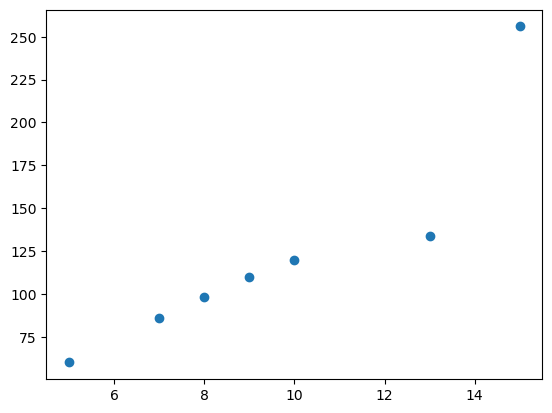

In [10]:
import matplotlib.pyplot as plt
plt.scatter(X,Y)

In [11]:
def fx(a):
    return slope*a+inter # y=mx+c -> x - input

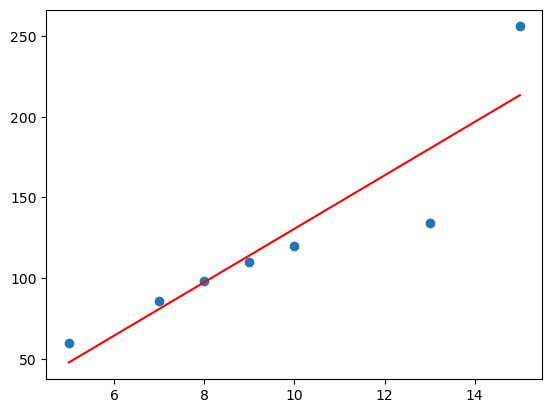

In [13]:
result = list(map(fx,X))
plt.scatter(X,Y)
plt.plot(X,result,'r')

In [15]:
print(fx(20))

296.2270916334661


In [16]:
print(fx(11))

147.0996015936255


In [ ]:
##############

In [ ]:
MLOps
MLOps = Data + ML + DevOps

Data - Keeps changing
Model - go stale
Training env inconsistent
...


In [17]:
import numpy as np
import pandas as pd

In [21]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# loaded dataset

data = {'pvalue':[1000,1500,2000,3000],
        'pcost':[150000,200000,25000,300000]}
df = pd.DataFrame(data)

## define feature input(X) and target(Y)
X = df[['pvalue']]
Y = df['pcost']

# create a model
model = LinearRegression()

# Train the model
model.fit(X,Y)

# Predict result - test - input
y_pred = model.predict(X)

# visualization

# model evaluation
r2_score(Y,y_pred)

0.21047239612976665

In [23]:
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.3,random_state=42)
|               |
model = LinerRegression()
model.fit(X_train,Y_train)
|
model.predict(X_test) ->pred
mean_squared_error(y_test,pred) -> mse


In [ ]:
the food good bad ---> Vector - numerical array
-----------------               ==================
OneHotEncoding
-----------------
       the food good bad

the =>  [ 1 0 0 0
food =>  0 1 0 0
good =>  0 0 1 0
bad  =>  0 0 0 1 ]

In [28]:
from sklearn.preprocessing import OneHotEncoder

df = pd.DataFrame({"K1":["the","food","good","bad"]})

encoder_obj = OneHotEncoder(sparse_output=False)
encoded = encoder_obj.fit_transform(df[['K1']])
print(encoded)
print(encoder_obj.get_feature_names_out())

[[0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]]
['K1_bad' 'K1_food' 'K1_good' 'K1_the']


In [ ]:
## General Workflow
|
Load data
Preprocess data (Categorical ->Numerical)
split data - train and test
|
Train the model
|
evaluation
|
Save the model -- for deployment  --> import joblib
                                      joblib.dump(model,"model-name.pkl")

...
# To use the saved model
joblib.load("model-name.pkl") ->loaded_model

In [ ]:
## End-to-End pipeline 
Loaded data - combined data - numerical + categorical 
|
|-> load the data
|-> separate features and target  -----------------------
|-> define preprocessing 
           |->feature engg
                          |->missing;duplicate;outlier..
           |-> text->number
|-> Combine pre-process data to column
   -----------------------------------------------------// pre-processing 
|-> split data into training and test
|-> create ML model
|-> train the model
|-> evaluate the model
|-> Save the trained model
|
|-> Predict - using saved model
|-> print/display prediction and test value
=========================================================================


In [ ]:
file: items.csv
-------------------------
color,size,value
red,small,10
blue,large,20
green,medium,30
blue,small,40

In [31]:
wobj = open("items.csv","w")
wobj.write("color,size,value\n")
wobj.write("red,small,10\n")
wobj.write("blue,large,20\n")
wobj.write("green,medium,30\n")
wobj.write("blue,small,40")
wobj.close()

In [32]:
print(open("items.csv").read())

color,size,value
red,small,10
blue,large,20
green,medium,30
blue,small,40


In [41]:
from sklearn.pipeline import Pipeline

In [47]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder,StandardScaler
from sklearn.compose import ColumnTransformer

In [53]:
df.columns

Index(['color', 'size', 'value'], dtype='object')

In [54]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression
import joblib

# load data
df = pd.read_csv("items.csv")

# separate features and target
X = df.drop(columns=["value"])
y = df["value"]

# features
numerical_features = []  # no numeric features
categorical_features = ["color", "size"]

# categorical transformer
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

# combine preprocessors
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", categorical_transformer, categorical_features)
    ]
)

# full pipeline
pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", LinearRegression())
])

# train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# train
pipeline.fit(X_train, y_train)

# evaluate
score = pipeline.score(X_test, y_test)
print("Model R-square:", score)

# save model
joblib.dump(pipeline, "my_linear_regression.pkl")

# load model
loaded_model = joblib.load("my_linear_regression.pkl")

# prediction
predictions = loaded_model.predict(X_test)
print("Predictions:", predictions)
print("Actual:", y_test.values)


Model R-square: nan
Predictions: [41.42857143]
Actual: [20]


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
